In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun 20 19:03:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
get_ipython().system('pip install git+https://github.com/qubvel/segmentation_models')

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-qp8pbfhw
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-qp8pbfhw
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 792kB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33810 sha256=9cb2fc02f6df505f9ff571971eae1b8b54e436c91f65f1dcb1b6d1d44e6f9af2
  Stored in directory: /tmp/pip-ephem-wheel-cache-w67tm0d9/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 16
NUM_CLASSES = 2
LABEL_PATH = '/content/drive/MyDrive/dark_field_/label/masks_label/'

In [ ]:
mask_files = os.listdir('/content/drive/MyDrive/dark_field_/sub_dark/masks/')
for mf in tqdm (mask_files):
    mask_img = cv2.imread(os.path.join('/content/drive/MyDrive/dark_field_/sub_dark/masks/', mf), cv2.IMREAD_GRAYSCALE)
    mask_img = np.around(tf.keras.utils.to_categorical(mask_img, NUM_CLASSES))
    cv2.imwrite(os.path.join('/content/drive/MyDrive/dark_field_/sub_dark/masks/', mf), mask_img)

FileNotFoundError: ignored

In [ ]:
def show_img(img, title=''):
    # given a numpy array, plot it
    vis = plt.imshow(img)
    plt.title(title)
    plt.show()

In [ ]:
def show_imgs(imgs, titles=None):
    # show two images side by side, useful for segmentation projects
    fig = plt.figure(figsize=(15, 15))

    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i+1)
        if titles:
            plt.title(titles[i])
        plt.imshow(imgs[i])
    
    plt.show()

In [ ]:
def label_to_image(m):
    # given a mask, turn it into an image, use for binary segmentations
    return tf.keras.preprocessing.image.array_to_img(m.reshape((m.shape[0], m.shape[1], 1)))


In [ ]:
def output_to_image(o):
    # given model output o that is one hot encoded, turn it into an image, use for multi class segmentations
    mask_im = tf.argmax(o, axis=-1)
    mask_im = tf.keras.preprocessing.image.array_to_img(mask_im[..., tf.newaxis])
    
    return mask_im 

In [ ]:
def visualise_source(title): 
    # given an image title, visualise the source data
    test_img = cv2.imread(os.path.join("/content/drive/MyDrive/dark_field/images/", title + '.png'))
    mask_img = cv2.imread(os.path.join(LABEL_PATH, title + '.png'), cv2.IMREAD_GRAYSCALE)
    show_imgs([test_img, mask_img])

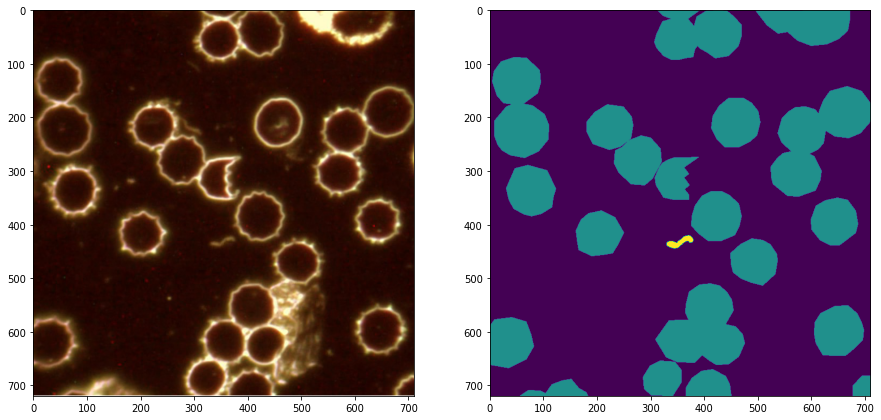

In [ ]:
visualise_source('001')

In [ ]:
   training_generation_args = dict(
#     width_shift_range=0.3,
#     height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.1
)

In [ ]:
train_image_datagen = ImageDataGenerator(**training_generation_args)
train_label_datagen = ImageDataGenerator(**training_generation_args)

In [ ]:
training_image_generator = train_image_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/dark_field',
    target_size=(256, 256),
    class_mode=None,
    subset='training',
    batch_size=16,
    
)

Found 330 images belonging to 1 classes.


In [ ]:
training_label_generator = train_label_datagen.flow_from_directory(
  directory='/content/drive/MyDrive/dark_field_/label/',
    target_size=(256, 256),
    class_mode=None,
    batch_size=16,
    subset='training',
    #color_mode='grayscale',
)

Found 330 images belonging to 1 classes.


In [ ]:
validation_image_generator = train_image_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/dark_field',
    target_size=(256, 256),
    class_mode=None,
    subset='validation',
    batch_size=16,
    seed=1
)

Found 36 images belonging to 1 classes.


In [ ]:
validation_label_generator = train_label_datagen          .flow_from_directory(
    directory='/content/drive/MyDrive/dark_field_/label/',
    target_size=(256, 256),
    class_mode=None,
    subset='validation',
    batch_size=16,
    # color_mode='grayscale',
    seed=1
)

Found 36 images belonging to 1 classes.


In [ ]:
train_generator = zip(training_image_generator, training_label_generator)
validation_generator = zip(validation_image_generator, validation_label_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


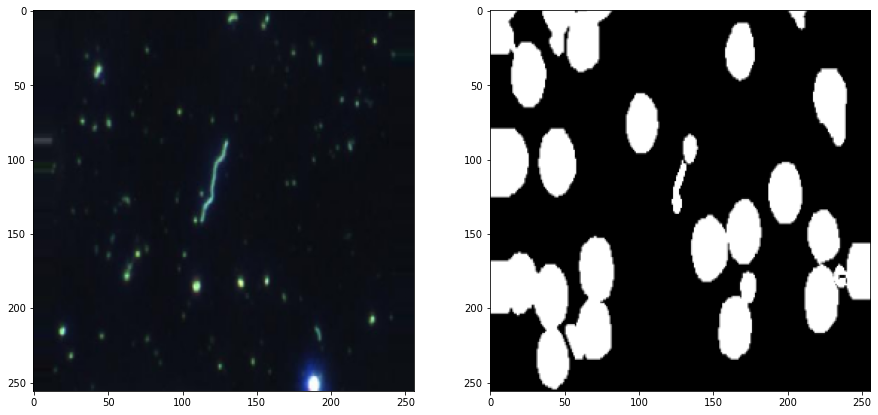

In [ ]:
test_imgs, labels = train_generator.__next__()
show_imgs([test_imgs[0] / 255., labels[0]])

In [ ]:
class_weight = {0:1.06, 1:7.17, 2:24.666}

In [ ]:
w = [[class_weight[0], class_weight[1], class_weight[2]]] * 256
h = [w] * 256
loss_mod = np.array(h)

In [ ]:
def dice_coef1(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss1(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
BACKBONE = 'resnet34'
from tensorflow import keras

# define model
model = Unet(BACKBONE, encoder_weights='imagenet',activation='relu')
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# fit model
model.fit(
   train_generator,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data=validation_generator,
                          validation_steps=9,
                          
)

Epoch 1/20
100/100 [==============================] - 70s 644ms/step - loss: nan - acc: 0.5439 - val_loss: nan - val_acc: 0.5707
Epoch 2/20
100/100 [==============================] - 63s 637ms/step - loss: nan - acc: 0.5439 - val_loss: nan - val_acc: 0.5665
Epoch 3/20
 17/100 [====>.........................] - ETA: 47s - loss: nan - acc: 0.5440

KeyboardInterrupt: ignored

In [ ]:
def label_to_image(m):
    # given a mask, turn it into an image, use for binary segmentations
    return tf.keras.preprocessing.image.array_to_img(m.reshape((m.shape[0], m.shape[1], 1)))


In [ ]:
def output_to_image(o):
    # given model output o that is one hot encoded, turn it into an image, use for multi class segmentations
    mask_im = tf.argmax(o, axis=-1)
    mask_im = tf.keras.preprocessing.image.array_to_img(mask_im[..., tf.newaxis])
    
    return mask_im

In [ ]:

train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/archive/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
            
train_images = np.array(train_images)
print(train_images.shape)

(366, 256, 256)


In [ ]:
train_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/archive/masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
                 
train_masks = np.array(train_masks)
print(train_masks.shape)

(366, 256, 256)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(train_masks.shape)
X_train = train_images
y_train = train_masks
y_train =np.expand_dims(y_train,axis=3)
print(y_train.shape)

(366, 256, 256)
(366, 256, 256, 1)


In [ ]:
get_ipython().system('pip install git+https://github.com/qubvel/segmentation_models')X_train = np.asarray(train_images).astype('float').reshape((-1,1))
y_train = np.asarray(train_masks).astype('float').reshape((-1,1))
y_train
#y_train.shape()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
get_ipython().system('pip install git+https://github.com/qubvel/segmentation_models')


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-et7i8fjv
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-et7i8fjv
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33810 sha256=a69ca389e8290bccb68562c7138140f11738ac151de575fcf2360327f35a886c
  Stored in directory: /tmp/pip-ephem-wheel-cache-9wa77h_w/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE = 'resnet34'


# define model
model = Unet(BACKBONE,classes=3, encoder_weights='imagenet',activation='softmax')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=10
)


Epoch 1/10


ValueError: ignored

(366, 256, 256, 64)


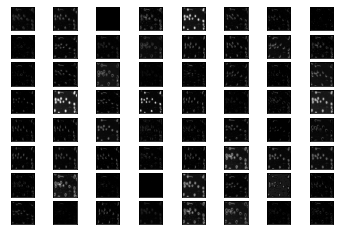

In [ ]:
 #this part of the code is not required 
print(features.shape)
#this block of code is not required 
# the following output images given bellow are called feature maps
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([]) 
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [ ]:

print(features.shape)
X=features

(366, 256, 256, 64)


In [ ]:
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

In [ ]:
print(X.shape)

(23986176, 64)


In [ ]:

print(train_masks.shape)
#Reshape Y to match X
Y = y_train.reshape(-1)
print(y_train.shape)
#shape is not matching i don't know why

(366, 256, 256)
(366, 256, 256, 1)


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['square']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


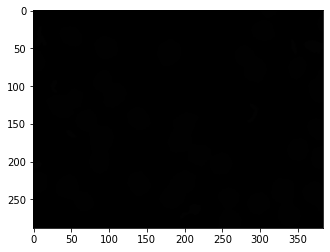

In [ ]:
get_ipython().run_line_magic('pylab', 'inline')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/archive/masks/365.png')
imgplot = plt.imshow(img)
plt.show()
#this is one of the masks but i can't see mask lol  

In [ ]:
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[0 1 2]
0    20093351
1     3644678
2      248147
Name: Label, dtype: int64


In [ ]:
dataset = dataset[dataset['Label'] != 0]

In [ ]:

X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']
print(X_for_RF.shape)
print(Y_for_RF.shape)

(3892825, 64)
(3892825,)


In [ ]:
#loss_weights = {1: 800.,2: 55000.}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42, verbose = 2, class_weight='balanced')

In [ ]:
model.fit(X_for_RF, Y_for_RF) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.8s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 48.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=2,
                       warm_start=False)

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/archive/images/357.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

In [ ]:
#taking out the feature of image
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

In [ ]:

#passing that to random forest
prediction = model.predict(X_test_feature)
#reve the #and excute the below line if the above one does't work.
#prediction= classifier.predict(X_test_feature)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished


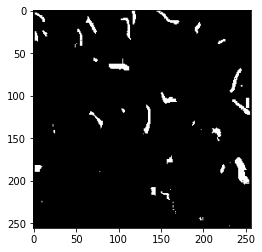

In [ ]:
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
#plt.imsave('images/test_images/360_segmented.jpg', prediction_image, cmap='gray')


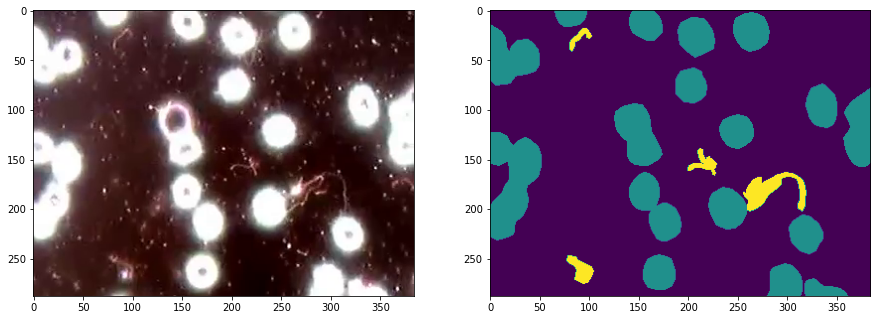

In [ ]:
visualise_source('357')